In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, random_state=0):
    
    np.random.seed(random_state)
    x = np.zeros((datanum, 10))
    for i in range(10):
        x[:, i:i+1] = np.random.uniform(0, 1,[datanum,1])
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = [x[:, [i]] for i in range(10)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = -3.5 + (8 * (x1 - 0.5) ** 2
           + 0.1 * np.exp(-8 * x2 + 4)
           + 3 * np.sin(2 * np.pi * x3 * x4)
           + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X1":{"type":'continuous'},
             'X2':{'type':'continuous'},
             'X3':{'type':'continuous'},
             'X4':{'type':'continuous'},
             'X5':{'type':'continuous'},
             'X6':{'type':'continuous'},
             'X7':{'type':'continuous'},
             'X8':{'type':'continuous'},
             'X9':{'type':'continuous'},
             'X10':{'type':'continuous'},
             'Y':{'type':'target'}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=5000, random_state=0)

## Train GAMI-Net 

In [3]:
model = GAMINet(meta_info=meta_info, interact_num=20, interact_arch=[20, 10],
            subnet_arch=[20, 10], task_type=task_type, activation_func=tf.tanh, main_grid_size=41, interact_grid_size=41,
            batch_size=min(500, int(0.2*train_x.shape[0])), lr_bp=0.001, main_effect_epochs=2000,
            interaction_epochs=2000, tuning_epochs=50, loss_threshold=0.01,
            verbose=True, val_ratio=0.2, early_stop_thres=100)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.13117, val loss: 0.13101
Main effects training epoch: 2, train loss: 0.12540, val loss: 0.12523
Main effects training epoch: 3, train loss: 0.12052, val loss: 0.12037
Main effects training epoch: 4, train loss: 0.11592, val loss: 0.11590
Main effects training epoch: 5, train loss: 0.11178, val loss: 0.11174
Main effects training epoch: 6, train loss: 0.10781, val loss: 0.10770
Main effects training epoch: 7, train loss: 0.10394, val loss: 0.10392
Main effects training epoch: 8, train loss: 0.10021, val loss: 0.10031
Main effects training epoch: 9, train loss: 0.09677, val loss: 0.09690
Main effects training epoch: 10, train loss: 0.09353, val loss: 0.09369
Main effects training epoch: 11, train loss: 0.09005, val loss: 0.09022
Main effects training epoch: 12, train loss: 0.08719, val loss: 0.08743
Main effects training e

Main effects training epoch: 116, train loss: 0.01004, val loss: 0.00991
Main effects training epoch: 117, train loss: 0.01002, val loss: 0.00991
Main effects training epoch: 118, train loss: 0.01003, val loss: 0.00996
Main effects training epoch: 119, train loss: 0.01001, val loss: 0.00991
Main effects training epoch: 120, train loss: 0.00997, val loss: 0.00985
Main effects training epoch: 121, train loss: 0.01007, val loss: 0.00998
Main effects training epoch: 122, train loss: 0.00998, val loss: 0.00987
Main effects training epoch: 123, train loss: 0.00994, val loss: 0.00983
Main effects training epoch: 124, train loss: 0.01002, val loss: 0.00993
Main effects training epoch: 125, train loss: 0.00996, val loss: 0.00981
Main effects training epoch: 126, train loss: 0.00995, val loss: 0.00985
Main effects training epoch: 127, train loss: 0.00996, val loss: 0.00987
Main effects training epoch: 128, train loss: 0.00994, val loss: 0.00983
Main effects training epoch: 129, train loss: 0.009

Main effects training epoch: 230, train loss: 0.00974, val loss: 0.00971
Main effects training epoch: 231, train loss: 0.00973, val loss: 0.00964
Main effects training epoch: 232, train loss: 0.00973, val loss: 0.00963
Main effects training epoch: 233, train loss: 0.00972, val loss: 0.00970
Main effects training epoch: 234, train loss: 0.00971, val loss: 0.00971
Main effects training epoch: 235, train loss: 0.00971, val loss: 0.00963
Main effects training epoch: 236, train loss: 0.00970, val loss: 0.00964
Main effects training epoch: 237, train loss: 0.00971, val loss: 0.00966
Main effects training epoch: 238, train loss: 0.00970, val loss: 0.00968
Main effects training epoch: 239, train loss: 0.00969, val loss: 0.00963
Main effects training epoch: 240, train loss: 0.00969, val loss: 0.00963
Main effects training epoch: 241, train loss: 0.00968, val loss: 0.00967
Main effects training epoch: 242, train loss: 0.00968, val loss: 0.00962
Main effects training epoch: 243, train loss: 0.009

Main effects training epoch: 344, train loss: 0.00937, val loss: 0.00938
Main effects training epoch: 345, train loss: 0.00937, val loss: 0.00924
Main effects training epoch: 346, train loss: 0.00937, val loss: 0.00924
Main effects training epoch: 347, train loss: 0.00937, val loss: 0.00932
Main effects training epoch: 348, train loss: 0.00936, val loss: 0.00933
Main effects training epoch: 349, train loss: 0.00936, val loss: 0.00928
Main effects training epoch: 350, train loss: 0.00936, val loss: 0.00926
Main effects training epoch: 351, train loss: 0.00936, val loss: 0.00938
Main effects training epoch: 352, train loss: 0.00935, val loss: 0.00931
Main effects training epoch: 353, train loss: 0.00936, val loss: 0.00920
Main effects training epoch: 354, train loss: 0.00935, val loss: 0.00928
Main effects training epoch: 355, train loss: 0.00934, val loss: 0.00930
Main effects training epoch: 356, train loss: 0.00933, val loss: 0.00926
Main effects training epoch: 357, train loss: 0.009

Main effects training epoch: 458, train loss: 0.00921, val loss: 0.00924
Main effects training epoch: 459, train loss: 0.00922, val loss: 0.00923
Main effects training epoch: 460, train loss: 0.00922, val loss: 0.00925
Main effects training epoch: 461, train loss: 0.00921, val loss: 0.00916
Main effects training epoch: 462, train loss: 0.00921, val loss: 0.00925
Main effects training epoch: 463, train loss: 0.00921, val loss: 0.00918
Main effects training epoch: 464, train loss: 0.00920, val loss: 0.00923
Main effects training epoch: 465, train loss: 0.00920, val loss: 0.00922
Main effects training epoch: 466, train loss: 0.00921, val loss: 0.00920
Main effects training epoch: 467, train loss: 0.00922, val loss: 0.00920
Main effects training epoch: 468, train loss: 0.00920, val loss: 0.00927
Main effects training epoch: 469, train loss: 0.00919, val loss: 0.00923
Main effects training epoch: 470, train loss: 0.00919, val loss: 0.00919
Main effects training epoch: 471, train loss: 0.009

Interaction training epoch: 12, train loss: 0.00589, val loss: 0.00603
Interaction training epoch: 13, train loss: 0.00580, val loss: 0.00595
Interaction training epoch: 14, train loss: 0.00573, val loss: 0.00597
Interaction training epoch: 15, train loss: 0.00575, val loss: 0.00593
Interaction training epoch: 16, train loss: 0.00548, val loss: 0.00573
Interaction training epoch: 17, train loss: 0.00545, val loss: 0.00575
Interaction training epoch: 18, train loss: 0.00541, val loss: 0.00572
Interaction training epoch: 19, train loss: 0.00544, val loss: 0.00576
Interaction training epoch: 20, train loss: 0.00538, val loss: 0.00567
Interaction training epoch: 21, train loss: 0.00535, val loss: 0.00565
Interaction training epoch: 22, train loss: 0.00537, val loss: 0.00567
Interaction training epoch: 23, train loss: 0.00530, val loss: 0.00562
Interaction training epoch: 24, train loss: 0.00528, val loss: 0.00559
Interaction training epoch: 25, train loss: 0.00530, val loss: 0.00562
Intera

Interaction training epoch: 128, train loss: 0.00344, val loss: 0.00375
Interaction training epoch: 129, train loss: 0.00340, val loss: 0.00365
Interaction training epoch: 130, train loss: 0.00338, val loss: 0.00365
Interaction training epoch: 131, train loss: 0.00339, val loss: 0.00369
Interaction training epoch: 132, train loss: 0.00338, val loss: 0.00363
Interaction training epoch: 133, train loss: 0.00336, val loss: 0.00365
Interaction training epoch: 134, train loss: 0.00334, val loss: 0.00361
Interaction training epoch: 135, train loss: 0.00336, val loss: 0.00365
Interaction training epoch: 136, train loss: 0.00332, val loss: 0.00363
Interaction training epoch: 137, train loss: 0.00332, val loss: 0.00358
Interaction training epoch: 138, train loss: 0.00332, val loss: 0.00360
Interaction training epoch: 139, train loss: 0.00330, val loss: 0.00361
Interaction training epoch: 140, train loss: 0.00330, val loss: 0.00358
Interaction training epoch: 141, train loss: 0.00329, val loss: 

Interaction training epoch: 243, train loss: 0.00269, val loss: 0.00303
Interaction training epoch: 244, train loss: 0.00270, val loss: 0.00302
Interaction training epoch: 245, train loss: 0.00269, val loss: 0.00302
Interaction training epoch: 246, train loss: 0.00269, val loss: 0.00300
Interaction training epoch: 247, train loss: 0.00268, val loss: 0.00299
Interaction training epoch: 248, train loss: 0.00268, val loss: 0.00303
Interaction training epoch: 249, train loss: 0.00267, val loss: 0.00299
Interaction training epoch: 250, train loss: 0.00267, val loss: 0.00300
Interaction training epoch: 251, train loss: 0.00266, val loss: 0.00299
Interaction training epoch: 252, train loss: 0.00266, val loss: 0.00298
Interaction training epoch: 253, train loss: 0.00266, val loss: 0.00297
Interaction training epoch: 254, train loss: 0.00266, val loss: 0.00298
Interaction training epoch: 255, train loss: 0.00265, val loss: 0.00299
Interaction training epoch: 256, train loss: 0.00265, val loss: 

Interaction training epoch: 357, train loss: 0.00234, val loss: 0.00260
Interaction training epoch: 358, train loss: 0.00235, val loss: 0.00259
Interaction training epoch: 359, train loss: 0.00234, val loss: 0.00261
Interaction training epoch: 360, train loss: 0.00233, val loss: 0.00260
Interaction training epoch: 361, train loss: 0.00234, val loss: 0.00258
Interaction training epoch: 362, train loss: 0.00234, val loss: 0.00261
Interaction training epoch: 363, train loss: 0.00232, val loss: 0.00258
Interaction training epoch: 364, train loss: 0.00233, val loss: 0.00258
Interaction training epoch: 365, train loss: 0.00233, val loss: 0.00260
Interaction training epoch: 366, train loss: 0.00232, val loss: 0.00257
Interaction training epoch: 367, train loss: 0.00232, val loss: 0.00259
Interaction training epoch: 368, train loss: 0.00231, val loss: 0.00258
Interaction training epoch: 369, train loss: 0.00233, val loss: 0.00259
Interaction training epoch: 370, train loss: 0.00233, val loss: 

Interaction training epoch: 471, train loss: 0.00220, val loss: 0.00249
Interaction training epoch: 472, train loss: 0.00220, val loss: 0.00251
Interaction training epoch: 473, train loss: 0.00219, val loss: 0.00250
Interaction training epoch: 474, train loss: 0.00219, val loss: 0.00249
Interaction training epoch: 475, train loss: 0.00219, val loss: 0.00249
Interaction training epoch: 476, train loss: 0.00219, val loss: 0.00250
Interaction training epoch: 477, train loss: 0.00219, val loss: 0.00249
Interaction training epoch: 478, train loss: 0.00219, val loss: 0.00248
Interaction training epoch: 479, train loss: 0.00219, val loss: 0.00250
Interaction training epoch: 480, train loss: 0.00220, val loss: 0.00250
Interaction training epoch: 481, train loss: 0.00219, val loss: 0.00248
Interaction training epoch: 482, train loss: 0.00219, val loss: 0.00251
Interaction training epoch: 483, train loss: 0.00219, val loss: 0.00248
Interaction training epoch: 484, train loss: 0.00219, val loss: 

Interaction training epoch: 585, train loss: 0.00213, val loss: 0.00245
Interaction training epoch: 586, train loss: 0.00213, val loss: 0.00244
Interaction training epoch: 587, train loss: 0.00213, val loss: 0.00243
Interaction training epoch: 588, train loss: 0.00213, val loss: 0.00244
Interaction training epoch: 589, train loss: 0.00214, val loss: 0.00247
Interaction training epoch: 590, train loss: 0.00214, val loss: 0.00245
Interaction training epoch: 591, train loss: 0.00213, val loss: 0.00246
Interaction training epoch: 592, train loss: 0.00212, val loss: 0.00245
Interaction training epoch: 593, train loss: 0.00212, val loss: 0.00244
Interaction training epoch: 594, train loss: 0.00212, val loss: 0.00243
Interaction training epoch: 595, train loss: 0.00212, val loss: 0.00243
Interaction training epoch: 596, train loss: 0.00213, val loss: 0.00242
Interaction training epoch: 597, train loss: 0.00212, val loss: 0.00242
Interaction training epoch: 598, train loss: 0.00212, val loss: 

Interaction training epoch: 699, train loss: 0.00209, val loss: 0.00242
Interaction training epoch: 700, train loss: 0.00208, val loss: 0.00240
Interaction training epoch: 701, train loss: 0.00208, val loss: 0.00241
Interaction training epoch: 702, train loss: 0.00208, val loss: 0.00239
Interaction training epoch: 703, train loss: 0.00208, val loss: 0.00240
Interaction training epoch: 704, train loss: 0.00208, val loss: 0.00240
Interaction training epoch: 705, train loss: 0.00208, val loss: 0.00240
Interaction training epoch: 706, train loss: 0.00207, val loss: 0.00240
Interaction training epoch: 707, train loss: 0.00208, val loss: 0.00239
Interaction training epoch: 708, train loss: 0.00208, val loss: 0.00241
Interaction training epoch: 709, train loss: 0.00207, val loss: 0.00240
Interaction training epoch: 710, train loss: 0.00208, val loss: 0.00240
Interaction training epoch: 711, train loss: 0.00207, val loss: 0.00240
Interaction training epoch: 712, train loss: 0.00208, val loss: 

Interaction training epoch: 813, train loss: 0.00204, val loss: 0.00237
Interaction training epoch: 814, train loss: 0.00205, val loss: 0.00237
Interaction training epoch: 815, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 816, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 817, train loss: 0.00205, val loss: 0.00236
Interaction training epoch: 818, train loss: 0.00204, val loss: 0.00237
Interaction training epoch: 819, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 820, train loss: 0.00204, val loss: 0.00235
Interaction training epoch: 821, train loss: 0.00204, val loss: 0.00237
Interaction training epoch: 822, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 823, train loss: 0.00204, val loss: 0.00237
Interaction training epoch: 824, train loss: 0.00204, val loss: 0.00234
Interaction training epoch: 825, train loss: 0.00204, val loss: 0.00236
Interaction training epoch: 826, train loss: 0.00204, val loss: 

Interaction training epoch: 927, train loss: 0.00202, val loss: 0.00233
Interaction training epoch: 928, train loss: 0.00201, val loss: 0.00232
Interaction training epoch: 929, train loss: 0.00201, val loss: 0.00232
Interaction training epoch: 930, train loss: 0.00201, val loss: 0.00233
Interaction training epoch: 931, train loss: 0.00201, val loss: 0.00233
Interaction training epoch: 932, train loss: 0.00201, val loss: 0.00233
Interaction training epoch: 933, train loss: 0.00201, val loss: 0.00233
Interaction training epoch: 934, train loss: 0.00201, val loss: 0.00234
Interaction training epoch: 935, train loss: 0.00202, val loss: 0.00233
Interaction training epoch: 936, train loss: 0.00202, val loss: 0.00234
Interaction training epoch: 937, train loss: 0.00201, val loss: 0.00232
Interaction training epoch: 938, train loss: 0.00201, val loss: 0.00233
Interaction training epoch: 939, train loss: 0.00201, val loss: 0.00232
Interaction training epoch: 940, train loss: 0.00201, val loss: 

Interaction training epoch: 1041, train loss: 0.00198, val loss: 0.00230
Interaction training epoch: 1042, train loss: 0.00199, val loss: 0.00232
Interaction training epoch: 1043, train loss: 0.00199, val loss: 0.00232
Interaction training epoch: 1044, train loss: 0.00199, val loss: 0.00231
Interaction training epoch: 1045, train loss: 0.00199, val loss: 0.00232
Interaction training epoch: 1046, train loss: 0.00199, val loss: 0.00230
Interaction training epoch: 1047, train loss: 0.00199, val loss: 0.00228
Interaction training epoch: 1048, train loss: 0.00199, val loss: 0.00231
Interaction training epoch: 1049, train loss: 0.00199, val loss: 0.00230
Interaction training epoch: 1050, train loss: 0.00200, val loss: 0.00230
Interaction training epoch: 1051, train loss: 0.00198, val loss: 0.00230
Interaction training epoch: 1052, train loss: 0.00199, val loss: 0.00230
Interaction training epoch: 1053, train loss: 0.00199, val loss: 0.00230
Interaction training epoch: 1054, train loss: 0.001

Interaction training epoch: 1155, train loss: 0.00197, val loss: 0.00228
Interaction training epoch: 1156, train loss: 0.00197, val loss: 0.00230
Interaction training epoch: 1157, train loss: 0.00196, val loss: 0.00228
Interaction training epoch: 1158, train loss: 0.00197, val loss: 0.00226
Interaction training epoch: 1159, train loss: 0.00198, val loss: 0.00227
Interaction training epoch: 1160, train loss: 0.00198, val loss: 0.00227
Interaction training epoch: 1161, train loss: 0.00197, val loss: 0.00227
Interaction training epoch: 1162, train loss: 0.00197, val loss: 0.00228
Interaction training epoch: 1163, train loss: 0.00196, val loss: 0.00228
Interaction training epoch: 1164, train loss: 0.00197, val loss: 0.00228
Interaction training epoch: 1165, train loss: 0.00197, val loss: 0.00229
Interaction training epoch: 1166, train loss: 0.00196, val loss: 0.00228
Interaction training epoch: 1167, train loss: 0.00196, val loss: 0.00228
Interaction training epoch: 1168, train loss: 0.001

Interaction training epoch: 1269, train loss: 0.00195, val loss: 0.00224
Interaction training epoch: 1270, train loss: 0.00195, val loss: 0.00227
Interaction training epoch: 1271, train loss: 0.00195, val loss: 0.00226
Interaction training epoch: 1272, train loss: 0.00195, val loss: 0.00226
Interaction training epoch: 1273, train loss: 0.00195, val loss: 0.00229
Interaction training epoch: 1274, train loss: 0.00195, val loss: 0.00227
Interaction training epoch: 1275, train loss: 0.00195, val loss: 0.00226
Interaction training epoch: 1276, train loss: 0.00195, val loss: 0.00227
Interaction training epoch: 1277, train loss: 0.00195, val loss: 0.00227
Interaction training epoch: 1278, train loss: 0.00195, val loss: 0.00225
Interaction training epoch: 1279, train loss: 0.00195, val loss: 0.00226
Interaction training epoch: 1280, train loss: 0.00195, val loss: 0.00227
Interaction training epoch: 1281, train loss: 0.00195, val loss: 0.00226
Interaction training epoch: 1282, train loss: 0.001

Interaction training epoch: 1383, train loss: 0.00194, val loss: 0.00226
Interaction training epoch: 1384, train loss: 0.00194, val loss: 0.00225
Interaction training epoch: 1385, train loss: 0.00194, val loss: 0.00225
Interaction training epoch: 1386, train loss: 0.00193, val loss: 0.00225
Interaction training epoch: 1387, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1388, train loss: 0.00193, val loss: 0.00227
Interaction training epoch: 1389, train loss: 0.00194, val loss: 0.00226
Interaction training epoch: 1390, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1391, train loss: 0.00194, val loss: 0.00226
Interaction training epoch: 1392, train loss: 0.00194, val loss: 0.00225
Interaction training epoch: 1393, train loss: 0.00194, val loss: 0.00226
Interaction training epoch: 1394, train loss: 0.00193, val loss: 0.00224
Interaction training epoch: 1395, train loss: 0.00193, val loss: 0.00226
Interaction training epoch: 1396, train loss: 0.001

## Visualization

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

NameError: name 'matplotlib' is not defined

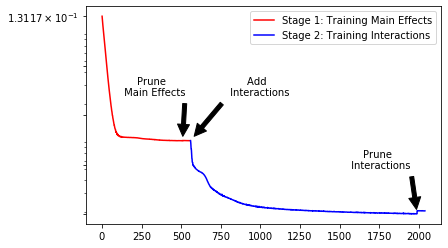

In [8]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

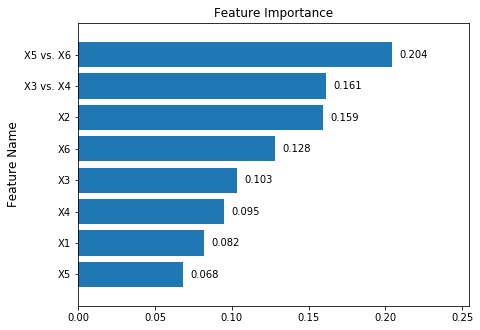

In [5]:
data_dict = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict, save_png=True, folder=simu_dir, name='s1_feature')

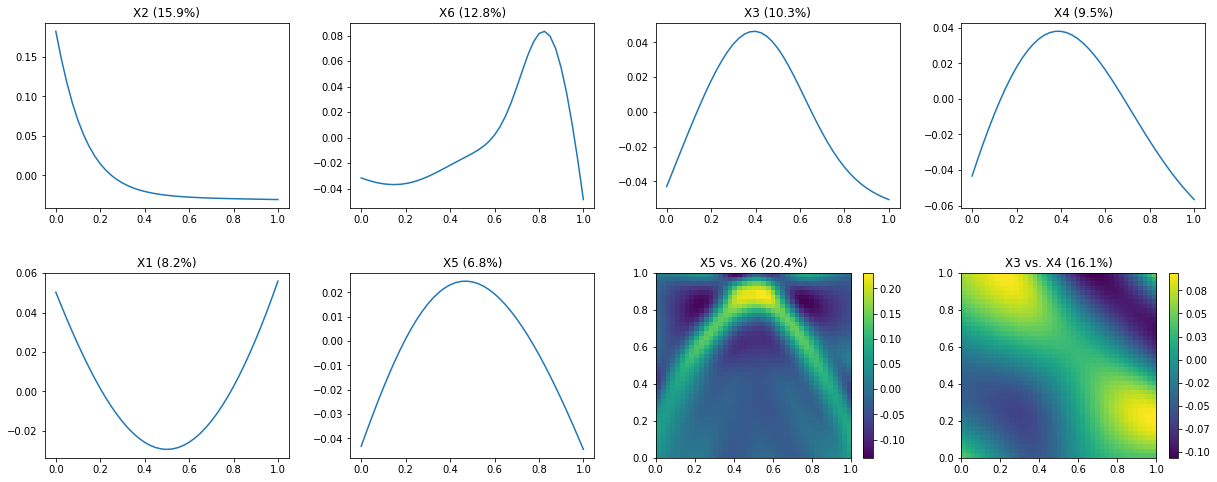

In [6]:
global_visualize_wo_density(data_dict, save_png=True, folder=simu_dir, name='s1_global')

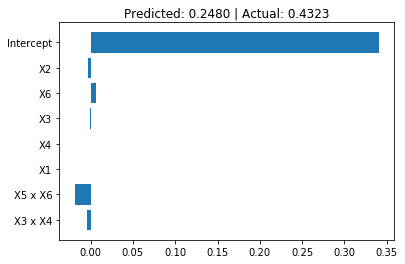

In [11]:
data_dict_local = model.local_explain(train_x[[110]], train_y[[2]], save_dict=False)
local_visualize(data_dict_local, save_png=True, folder=simu_dir, name='s1_local')

In [16]:
x = train_x[[110]]
main_effect_output = model.maineffect_blocks.__call__(tf.cast(tf.constant(x), tf.float32)).numpy()
interaction_output = model.interact_blocks.__call__(tf.cast(tf.constant(x), tf.float32)).numpy()

In [22]:
intercept = model.output_layer.main_effect_output_bias.numpy() + model.output_layer.interaction_output_bias.numpy()
active_main_effect_index, active_interaction_index, beta, gamma, componment_scales = model.get_all_active_rank()
scores = np.hstack([intercept[0], (np.hstack([main_effect_output.ravel(), interaction_output.ravel()]) 
                                   * np.hstack([beta.ravel(), gamma.ravel()]).ravel()).ravel()])
scores

array([ 3.40743929e-01,  3.19451759e-04, -2.95052142e-03, -3.71608669e-04,
        9.86990734e-04, -1.33918232e-04,  6.88717977e-03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.34214896e-03,
       -1.90152631e-02,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

In [26]:
beta.ravel(), gamma.ravel()

(array([ 0.02606551,  0.05079081, -0.0330056 , -0.03020236, -0.02170944,
         0.0408346 , -0.        ,  0.        ,  0.        ,  0.        ],
       dtype=float32),
 array([ 0.05148497,  0.06525351, -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        , -0.        , -0.        ,  0.        ,  0.        ]))

In [41]:
main_effect_weights, interaction_weights

(array([ 0.87762034,  0.30024806, -0.26583764, -0.5776517 , -0.65483725,
         0.491878  , -0.        ,  0.        ,  0.        ,  0.        ],
       dtype=float32),
 array([ 0.56370306,  0.45756906, -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        , -0.        , -0.        ,  0.        ,  0.        ]))

In [43]:
np.zeros((5))

array([0., 0., 0., 0., 0.])

In [50]:
    intercept = model.output_layer.main_effect_output_bias.numpy() + model.output_layer.interaction_output_bias.numpy()

    main_effect_output = model.maineffect_blocks.__call__(tf.cast(tf.constant(x), tf.float32)).numpy().ravel()
    if model.interact_num > 0:
        interaction_output = model.interact_blocks.__call__(tf.cast(tf.constant(x), tf.float32)).numpy().ravel()
    else:
        interaction_output = np.array([])

    main_effect_weights = ((model.output_layer.main_effect_weights.numpy()) * model.output_layer.main_effect_switcher.numpy()).ravel()
    interaction_weights = ((model.output_layer.interaction_weights.numpy()[:model.interact_num_added])
                          * model.output_layer.interaction_switcher.numpy()[:model.interact_num_added]).ravel()
    interaction_weights = np.hstack([interaction_weights, np.zeros((model.interact_num - model.interact_num_added))]) 

    scores = np.hstack([intercept[0], np.hstack([main_effect_weights, interaction_weights]) 
                                      * np.hstack([main_effect_output, interaction_output])])

In [51]:
scores

array([ 0.34074393,  0.01075588, -0.0174419 , -0.00299306,  0.01887723,
       -0.00403947,  0.08296034, -0.        , -0.        ,  0.        ,
        0.        , -0.04754169, -0.13333836,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ])

In [52]:
scores.sum()

0.24798289459266343

In [30]:
scores

array([ 0.34074393,  0.01075588, -0.0174419 , -0.00299306,  0.01887723,
       -0.00403947,  0.08296034, -0.        , -0.        ,  0.        ,
        0.        , -0.04754169, -0.13333836,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ])

In [27]:
model.predict(x)

array([[0.24798289]], dtype=float32)

In [18]:
main_effect_output, interaction_output

(array([[ 0.01225573, -0.05809164,  0.01125896, -0.03267926,  0.00616866,
          0.1686604 ,  0.01941633, -0.00278729,  0.0061211 ,  0.01168442]],
       dtype=float32),
 array([[-0.08433819, -0.29140598, -0.01160675,  0.01144126,  0.01688862,
          0.00425628, -0.00231359,  0.00714806,  0.01033542, -0.00346768,
          0.0003981 , -0.02045788,  0.00562048, -0.00381764,  0.01053594,
          0.00457299,  0.00084845,  0.02206986, -0.00219752, -0.00872064]],
       dtype=float32))

In [14]:
data_dict_local['scores'].sum()

0.3221240910545601